# Autonomous Systems - Deep Learning
### Project Task 2 - Face Recognition with Transferlearning.
Create a neural network to recognize your face and clearly discern it from other faces and objects!

#### Markus Ullenbruch

This notebook was executed and implemented in Windows 10 operating system. Due to the corona pandemie I was not able to test the code on a Linux operating system at university.

# 0. Introduction
The scope of the project work of the lecture "Autonomous Systems - Deep Learning" is to implement software to recognize my own face and clearly discern it from other human faces and objects. <br>
This task must be addressed and solved using deep learning with transfer learning and the framework that will be used is tensorflow as the backend and the High-level API Keras in the python programming language.

The problem in deep learning and facial recognition is that we do not "hardcode" mathematical rules and alghotihms to recognize the classes. Deep Learning learns from experience, that means looking at labeled training data, making predictions on it, compare these predictions with the ground truth label and then optimize a error loss function based on the predictions. Optimize the error loss function means to search for the global minimum.

To solve this task, big amount of data is needed in order to secure a good performance of the deep learning model.
Based on the training data on which a deep learning model is trained on, the model should generalize from that training data to unseen data, so that the model can make predictions on this new and unseen data. This is very important because in real life applications you need to make predictions on new data that the model was not trained on! Real life applications can be to unlock the smartphone screen when a specific face looks onto the screen or to get access to rooms in companies per face recognition.

In order to train the model properly and provide good performance, the quality of the data is from very high importance.
A dataset will be presented in this project where 40% of the data is created by myself and the other 60% of the data was downloaded from research and educational datasets, provided in the internet from different sources. The dataset which is uploaded with this notebook contains prepared data on which training can be done.
The deep learning network will be created based on the gained knowledge during the lecture from Prof. Dr.-Ing. Stache.

First the used dataset is described and the data preparation is done, then the neural network is trained based this prepared dataset and in the last steps an evaluation of the resulting model and a discussion of the results is presented. <br>
Before the discussion of the results, a second model, which is designed to work efficiently on mobile devices, is also trained and shortly evaluated.

# 1. Load modules and packages

First all the needed modules and packages are imported to provide all the functionality und functions we need to solve the task.
For example, many keras functionalities are imported in order to set up the deep learning model structure and to train it. The os module is imported to handle relative and absolute paths safely on different operating systems and provide executability of the implementation. 
Other modules like PIL are imported to perform image manipulations, numpy for scientific calculations and matplotlib to plot graphs and results.

In [2]:
# Import all the relevant packages used in this project
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image

In a next step, it is checked wether a GPU (Graphics Processing Unit) is available to speed up the training process.
With a GPU the network could be trained a lot faster, which is more comfortable due to fine tuning the hyperparameters based on the training and validation dataset.
A GPU was used to fine tune the model at a friend's computer (Nvidia GeForce GTX 1080 Ti) since I don't own a GPU.

In [2]:
# Check if GPU is available
print('GPU available: ', tf.test.is_gpu_available())
print('TF Session: ', tf.keras.backend.clear_session())

GPU available:  True
TF Session:  None


# 2. The Raw Dataset
Getting and collecting data is the most crucial and important part when it comes to make predictions with a deep neural network. Often it is a very underestimated and very time consuming activity to get, create and prepare the data for data science projects. <br>
Examples of the dataset will be shown later in this notebook. <br>
For the classification task, three classes were used. In the following the used dataset, sources and classes are described:
### 2.1 Class "Markus"
One of the tasks of this project is to collect and create own data. To get the data of my own face, datasamples of the category "Markus" are created by myself. <br>
Images were made with an iPhone 8 with its 7 Megapixel front camera and saved as JPEG file format. Selfies were made from slightly varrying distances, but it was importand to try to match the positions of the faces of other humans in the dataset "Others", so that the relevant features from the faces can be learnt and not for example the camera position or the background as main feature to make predictions on. <br>
The images are quadratic and the whole face including hair and a little bit of the t-shiert is seen on the foto. A little background and clothes of myself are seen on the images. Images were made with different t-shierts/pullovers and in front of different backgrounds. <br>
Sometimes I made a foto series of 50 fotos in a row in a few seconds with the foto-series function of the iPhone, slightly varying the angle or distance of the camera with my arm while taking the images. <br>
Examples of the images are shown later in this notebook.
### 2.2 Class "Others"
The photos of random human faces were downloaded from the data science related website kaggle, which are offering the images for free and with non commercial research and educational purposes only. <br>
The dataset is the Flickr-Faces-HQ Dataset (FFHQ) downloaded from https://www.kaggle.com/arnaud58/flickrfaceshq-dataset-ffhq/data <br>

This dataset consists of 52.000 PNG images at a quadratic resolution of 512×512 and contains different groups of people due to age, ethnicity, nationality, hairstyle, clothes, facial expression and image background. The original source of the images is Flickr and were web scraped from there. The original images were automatically aligned and cropped by the creators using dlib.

The dataset is originally created from:

A Style-Based Generator Architecture for Generative Adversarial Networks <br>
Tero Karras (NVIDIA), Samuli Laine (NVIDIA), Timo Aila (NVIDIA) <br>
https://arxiv.org/abs/1812.04948


### 2.3 Class "Objects"
A dataset of objects was downloaded containing objects like ships, cars, aircrafts, bags, pencils, machines etc.
It contains 1852 different objects and has over 26.000 images. <br>
This dataset is the "THINGS object concept and object image database" downloaded from: https://osf.io/jum2f/

The dataset is created by:

THINGS: A database of 1,854 object concepts and more than 26,000 naturalistic object images. <br>
Martin N. Hebart, Adam H. Dickter, Alexis Kidder, Wan Y. Kwok, Anna Corriveau, Caitlin Van Wicklin & Chris I. Baker <br>
Laboratory  of  Brain  and Cognition,  National  Institute  of  Mental  Health,  National  Institutes  of  Health, Bethesda MD, USA


Hint: Examples of the preprocessed data are shown in Chapter "4. Examples of the data" and more specific information of the (preprocessed) image dataset is showed in Chapter "3. Data Preparation".

# 3. Data Preparation

### 3.1 What is done?
First the folder structure of the processed and prepared training, validation and test images of the classes are checked wether they are empty or containing processed data. If one folder is empty the data preparation of that specific class is done and if processed data is available for that specific class in every training, validation and test folder, nothing is done. <br>

When data preparation is executed e.g. for the class "Markus", then all images of the class "Markus" in training, validation and test folders are deleted. <br>
The raw image fotos (jpeg or png files) are then cropped to have the same view of the faces in both datasets "Markus" and "Others" and then they are resized to match the image size of the neural network (240x240) and to decrease the memory size of the images in order to upload them into ILIAS. <br>
Splitting up the processed data in Training, Validation and Testing datasets and saving them in the corresponding folder structure is also done in the preparation process.  <br>
The target file format of the preprocessed data is JPEG file format and is uploaded in ILIAS along with this jupyter notebook.

### 3.2 Folder Structure of the dataset
The folders which contains the processed training, validation and test dataset is set up in the following folder structure:

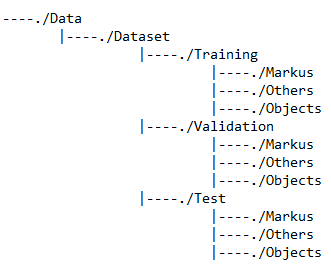

This specific folder structure is important so that we can feed the data to our model during training process with Keras.

In [4]:
# Predefine values for data preparation
IMG_SIZE = (240, 240) # Target Image size to resize the raw images
quality_val = 100 # quality value to save the file as .jpg

#### Markus Dataset

In [4]:
# Define the paths of training, validation and test data of "Markus"
train_path_markus =  './Data/Dataset/Training/Markus'
val_path_markus =  './Data/Dataset/Validation/Markus'
test_path_markus =  './Data/Dataset/Test/Markus'

In [5]:
# If one folder contains no images, then start preparation process
if len(os.listdir(train_path_markus))==0 or len(os.listdir(val_path_markus))==0 or len(os.listdir(test_path_markus))==0:
    print("Execution of Data Preparation startetd!")
    path_markus_raw = os.path.join(os.getcwd(), r'./Raw_Data_Markus') # path to raw images of my face
    data = os.listdir(path_markus_raw) # List containing all filenames of the raw images of class "Markus"
    
    # Split up the list of filenames in list of filenames of train, validation & test data
    train, val = train_test_split(data, test_size=0.15, shuffle=True)
    train, test = train_test_split(train, test_size=0.1, shuffle=True)
    
    # Delete all remaining files in the train, validation and test folder of "Markus"
    for x in [train_path_markus, val_path_markus, test_path_markus]:
        filelist = [f for f in os.listdir(x)]
        for f in filelist:
            os.remove(os.path.join(x, f))
    
    x = 300  # Quadratic crop size
    # Loop through splited up training, validation and test image files and paths to save them
    for datanames, save_path in [[train, train_path_markus], [val, val_path_markus], [test, test_path_markus]]:
        # Loop through every image filename in corresponding train, val or test folder
        for filename in datanames:
            # Only process .jpg image files
            if filename.endswith('.JPG') or filename.endswith('.jpg'):
                # Open an image as an array
                img = Image.open(os.path.join(path_markus_raw, filename))
                # Get image width and height
                w, h = img.size
                
                # Check if image is quadratic
                if w == h:
                    # Specify box coordinates to crop image
                    left, upper, right, lower = x, x, w-x, h-x
                    # Crop and resize image
                    img = img.crop((left, upper, right, lower))
                    img = img.resize(IMG_SIZE, Image.ANTIALIAS)
                    # Rotate image 90 deg because PIL considers Metadata of iPhone camera to rotate image
                    img = img.rotate(-90)
                    img.save(os.path.join(save_path, filename), 'JPEG', quality=quality_val)
                # If image is not quadratic do following  
                else:
                    if w < h:
                        # Specify box coordinates to crop image
                        left, upper, right, lower = 0, (h-w)//2, w, h - (h-w)//2
                        img = img.crop((left, upper, right, lower))
                        img = img.rotate(-90)
                    else:
                        left, upper, right, lower = (w-h)//2, 0, w - (w-h)//2, h 
                        img = img.crop((left, upper, right, lower))
                        img = img.rotate(-90)
                    img = img.resize(IMG_SIZE, Image.ANTIALIAS)
                    img.save(os.path.join(save_path, filename), 'JPEG', quality=quality_val)
            else:
                print('File' ,filename, 'is no JPG format!')
    
else:    
    print("Data is already processed and prepared!")

Data is already processed and prepared!


#### Others Dataset

In [6]:
# Define the paths of training, validation and test data of "Others"
train_path_others =  './Data/Dataset/Training/Others'
val_path_others =  './Data/Dataset/Validation/Others'
test_path_others =  './Data/Dataset/Test/Others'

In [7]:
# If one folder contains no images, then start preparation process
if len(os.listdir(train_path_others))==0 or len(os.listdir(val_path_others))==0 or len(os.listdir(test_path_others))==0:
    print("Execution of Data Preparation startetd!")
    # Path to raw 512x512 FlickR images of other human faces
    path_others_raw = os.path.join(os.getcwd(), './Raw_Data_Others')
    
    # List with all filenames of the raw images of class "Others"
    data = os.listdir(path_others_raw)
    
    # Split up the list of filenames in list of filenames of train, validation & test data
    train, val = train_test_split(data, test_size=0.15, shuffle=True)
    train, test = train_test_split(train, test_size=0.1, shuffle=True)
    
    # Delete all the existing files in the train, validation and test folder of "Others"
    for x in [train_path_others, val_path_others, test_path_others]:
        filelist = [f for f in os.listdir(x)]
        for f in filelist:
            os.remove(os.path.join(x, f))      
    
    x = 60 # quadratic crop size to crop the raw images before resizing
    # Loop through splited up training, validation and test image files and paths to save them
    for datanames, save_path in [[train, train_path_others], [val, val_path_others], [test, test_path_others]]:
        # Loop through every image filename in corresponding train, val or test folder
        for filename in datanames:
            # Only process .png image files
            if filename.endswith('.PNG') or filename.endswith('.png'):
                # Open an image as array and get width and height
                img = Image.open(os.path.join(path_others_raw, filename))
                w, h = img.size # get image width and height
                # Check if image is quadratic, it should be
                if w == h:
                    # Specify box coordinates to crop image
                    left, upper, right, lower = x, x, w-x, h-x
                    # Crop and resize image
                    img = img.crop((left, upper, right, lower))
                    img = img.resize(IMG_SIZE, Image.ANTIALIAS)
                    # In order to save as .jpg file, the ending of the filename must be changed from .png to .jpg
                    filename = filename.replace('.png', '.JPG')
                    # Save processed image as .jpg file
                    img.save(os.path.join(save_path, filename), 'JPEG', quality=quality_val)
                else:
                    print('File' ,filename, 'is not quadratic!')
            else:
                print('File' ,filename, 'is no PNG format!')
    
else:    
    print("Data is already processed and prepared!")

Data is already processed and prepared!


#### Objects Dataset

In [8]:
# Define the paths of training, validation and test data of "Objects"
train_path_objects = './Data/Dataset/Training/Objects'
val_path_objects = './Data/Dataset/Validation/Objects'
test_path_objects = './Data/Dataset/Test/Objects'

In [9]:
if len(os.listdir(train_path_objects))==0 or len(os.listdir(val_path_objects))==0 or len(os.listdir(test_path_objects))==0:
    print("Execution of Data Preparation startetd!")
    path_objects_raw = os.path.join(os.getcwd() ,'./Raw_Data_Objects')
    
    filenames = os.listdir(path_objects_raw)
    print(len(filenames), 'Raw Data Images for Class Objects')
    
    train, val = train_test_split(filenames, test_size=0.15, shuffle=True)
    train, test = train_test_split(train, test_size=0.1, shuffle=True)
    
    
    for x in [train_path_objects, val_path_objects, test_path_objects]:
        filelist = [f for f in os.listdir(x)]
        for f in filelist:
            os.remove(os.path.join(x, f))
            
    for datanames, save_path in [[train, train_path_objects], [val, val_path_objects], [test, test_path_objects]]:
        for filename in datanames:
            if filename.endswith('.JPG') or filename.endswith('.jpg'):
                img = Image.open(os.path.join(path_objects_raw, filename))
                w, h = img.size
                if w == h:
                    new_img = img.resize(IMG_SIZE, Image.ANTIALIAS)
                    new_img.save(os.path.join(save_path, filename), 'JPEG', quality=quality_val)
                else:
                    print('File' ,filename, 'is not quadratic like expected!')
            else:
                print('File' ,filename, 'is no JPG format!')

else:    
    print("Data is already processed and prepared!")

Data is already processed and prepared!


### 3.3 Dataset Sample Information
The following chart contains information about the sample size of the dataset in absolute and relative numbers of image samples and information about the content of the dataset.

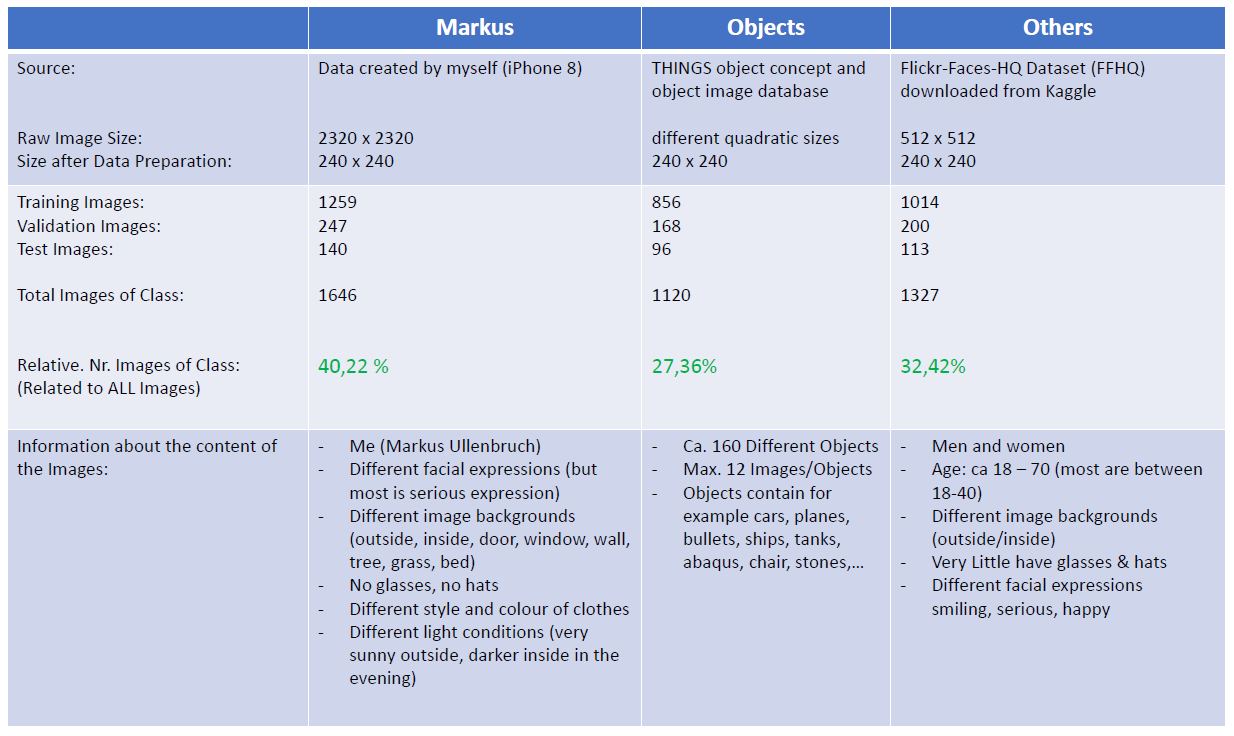

### 3.4 Define training, validation and test path for Keras

In [6]:
# All image data is resized to the following image size
IMAGE_SIZE = [240, 240]

In [10]:
# Training, validation and test data paths are defined with os module:
train_path = './Data/Dataset/Training'
validation_path = './Data/Dataset/Validation'
test_path = './Data/Dataset/Test'
class_names = ['/Markus', '/Others', '/Objects']

image_files = []
for clname in class_names:
    image_files += os.listdir(train_path + clname)

    
validation_image_files = []
for clname in class_names:
    validation_image_files += os.listdir(validation_path + clname)
    
    
test_image_files = []
for clname in class_names:
    test_image_files += os.listdir(test_path + clname)


print('Number of Training Images: ', len(image_files))
print('Number of Validation Images: ', len(validation_image_files))
print('Number of Test Images: ', len(test_image_files))
print('\nNumber of Total Images: ', len(test_image_files)+len(validation_image_files)+len(image_files))

# How many classes are available due to the folder structure:
folders = glob(train_path + '/*')
print('\nNumber of classes: ', len(folders))

Number of Training Images:  3129
Number of Validation Images:  615
Number of Test Images:  349

Number of Total Images:  4093

Number of classes:  3


# 4. Examples of the data
In the following section, examples of the preprocessed dataset from all classes are shown.

In [12]:
# Function to plot 4 (by default) randomly chosen images from a given path
def random_imageplot(path, num=4):
    """Plot randomn images from a given path."""
    liste = os.listdir(path)  # Create list of all filenames available in path
    for _ in range(num):  # Iterate num-times (default num=4)
        img_path = np.random.choice(liste)  # Pick a random imagename from liste
        img = image.load_img(os.path.join(path,img_path))  # Load the random-chosen image
        plt.imshow(img)
        plt.title('Image Size: ' + str(img.size))
        plt.xlabel('u [px]') 
        plt.ylabel('v [px]')
        plt.show()

### 4.1 Self created data - "Markus"
This is the data i have created on my own with a smartphone front camera (iPhone 8). Data is showed from all three training, validation and test dataset.

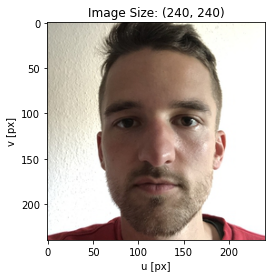

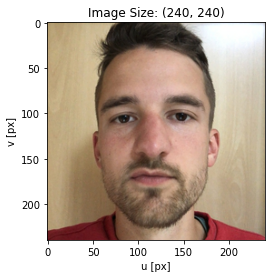

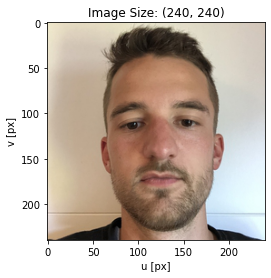

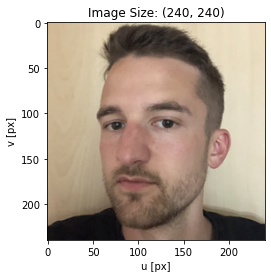

In [13]:
# Plot random chosen images of class "Markus" from the training dataset
random_imageplot(os.path.join(train_path, 'Markus'), 4)

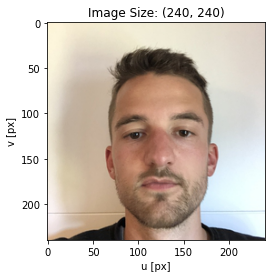

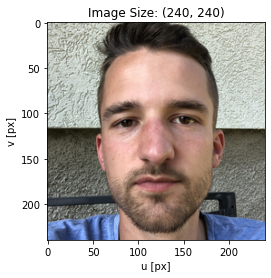

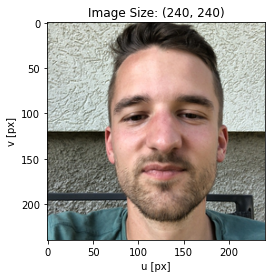

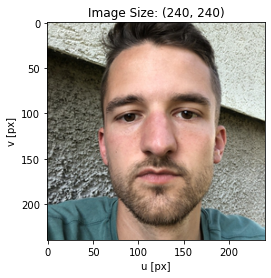

In [14]:
# Plot random chosen images of class "Markus" from the validation dataset
random_imageplot(os.path.join(validation_path, 'Markus'), 4)

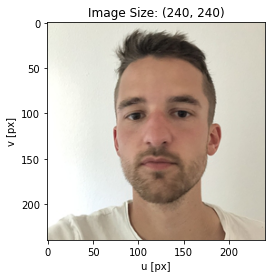

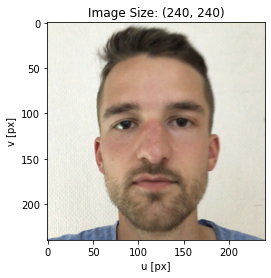

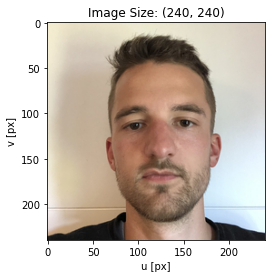

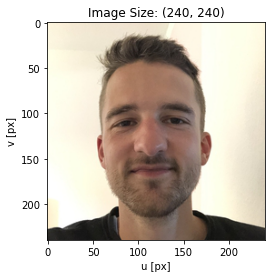

In [15]:
# Plot random chosen images of class "Markus" from the test dataset
random_imageplot(os.path.join(test_path, 'Markus'), 4)

### 4.2 The Dataset - "Others"
This is the dataset from other human faces from the Flickr-Faces-HQ Dataset (FFHQ) downloaded from https://www.kaggle.com/arnaud58/flickrfaceshq-dataset-ffhq/data.'. Only random images from the training dataset are showed.

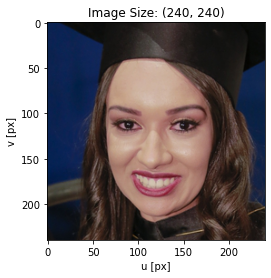

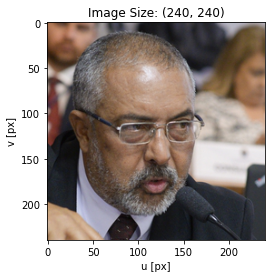

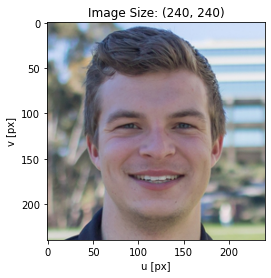

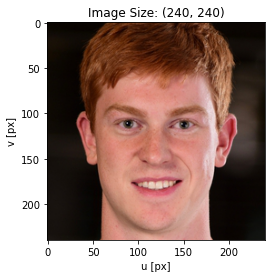

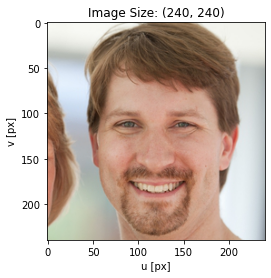

In [16]:
# Plot random chosen images of class "Others" from the training dataset
random_imageplot(os.path.join(train_path, 'Others'), 5)

### 4.3. The Dataset - "Objects"
"THINGS object concept and object image database" downloaded from: https://osf.io/jum2f/. Only random images from the training dataset are showed.

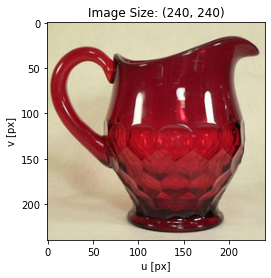

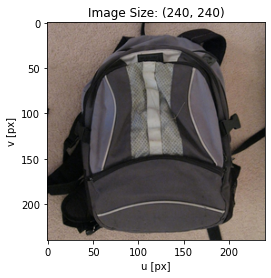

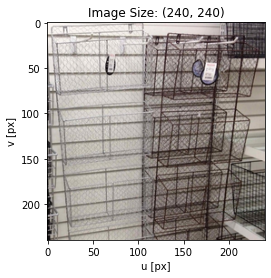

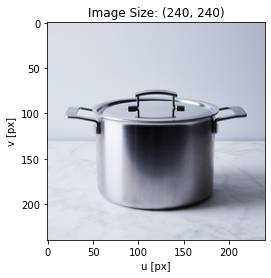

In [17]:
# Plot random chosen images of class "Objects" from the training dataset
random_imageplot(os.path.join(train_path, 'Objects'), 4)

# 5. Network Training

### 5.1 The Deep Neural Network Model - Transfer Learning 
Since transfer learning is used in this task, a already pretrained network will be used here. The following image from mathworks describes the pipeline of the Transfer learning process applied in this Notebook:
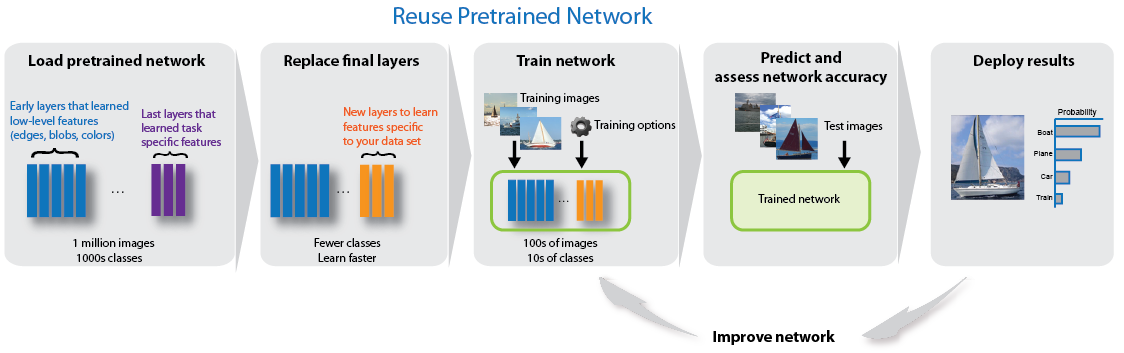
source of image: https://de.mathworks.com/help/deeplearning/ug/train-deep-learning-network-to-classify-new-images.html

First, the pretrained network is loaded and the top layers (fully connected layers), which are the classifying layers based on the extracted features from the layers before, are replaced by our own layers.

Then the network will be trained, but only the weights of our own defined fully-connected top layers are changed. The weights of the base model, which is extracting the features with Convolutional layers will not be trained.

In the next step, the accuracy, precision and recall of the resulting model will be evaluated based on the training, validation and test dataset.

In the last step the resulting model and its results are plotted and visualized.
The results of the model, like accuracy of the validation dataset, can be used in a feedback loop back to the training process to finetune the hyperparameters.

### 5.2 Load the network - InceptionResNetV2

For transfer learning, we need to load a pre-built and pre-trained deep neural network architecture. I decided to use the InceptionResNetV2 model.
It was trained on the imagenet dataset, which weights are specifically loaded in this notebook.
The input size is defined as the above chosen image size (240, 240) plus the three color channels for the RGB color space.

The top layers of the network are specifically not loaded on top of the model with include_top=False. This step is crucial for the transfer learning since we want to train the model only on those layers we are including by our own on top of the model output without top layers. The network should then be trained on how to classify my own three classes based on the feature extraction of the base model of the pretrained network.

In the following, the InceptionResNetV2 model is defined without top layers as the base_model.
On top of this base model, we can define layers over layers as we want! <br>
The weights of the base model are set to be freezed, which means, they will not be trained during the training process! Only the weights of our custom defined top layers we set on top will be trained in the whole training process, learning to do the classification task.

In [7]:
# Import the InceptionResNetV2 deep neural network model without top layers and load weights based on imagenet
base_model = InceptionResNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

### 5.3 Add layers to base model
Generate a Keras Model, double check the final structure and compile it.

In [8]:
def create_model():
    """Set up the deep neural network based on Inception ResNetV2 model and return the created model"""
    
    # Do not train pretrained base_model weights and freeze them
    for layer in base_model.layers:
        layer.trainable = False

    # Flatten the output tensor of the base_model
    x = Flatten()(base_model.output)
    # Connect a Dense layer to the flattened output
    prediction = Dense(len(folders),
                       activation='softmax')(x)

    # Create a model object from inputs and outputs of the whole architecture
    model = Model(inputs=base_model.input, outputs=prediction)

    # Print the structure of the resulting deep learning model
    print(model.summary())

    # Define the cost and optimization method of the model to use in the training process
    model.compile(
      loss='categorical_crossentropy', # loss for categorical data
      optimizer='rmsprop', 
      metrics=['accuracy'])
    return model

# Instantiate our model object for the training, validation and testing process
model = create_model()

NameError: name 'folders' is not defined

The output of the convolutional layers of the base model will be flattened, meaning reshaping the output tensor to a 1D vector. This 1D vector will be the input to the fully connected layer to classify the images.

With the Keras "Dense" function, a fully connected prediction layer is created with 3 neurons (because we have 3 classes to predict). The flattened 1D layer is fully connected to this prediction layer. <br>
The following image shows the structure of the classification layer and its integration to the base model:

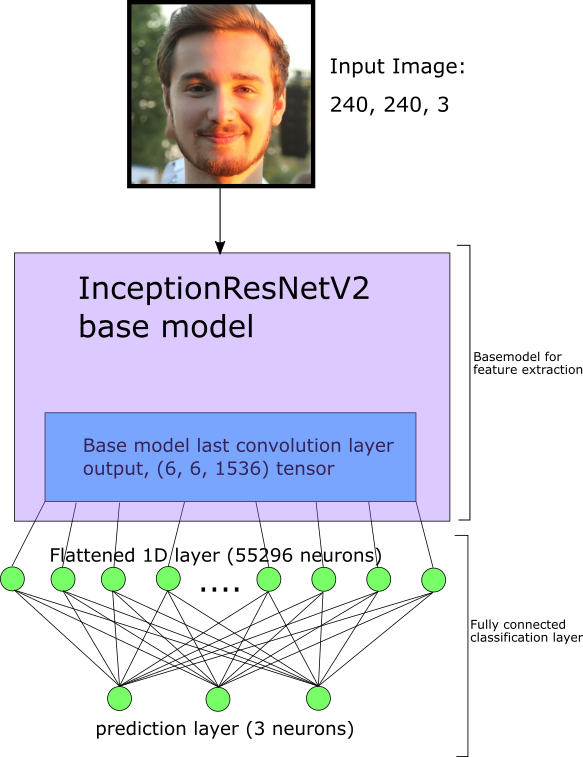

Overfitting is a phenomenon in machine learning that occurs when a machine learning model learns the training data by hard so the model is specificaly tailored to the training dataset and cannot generalise to other, for the network unseen, datasets.
With the above defined layers no overfitting occurs.

### 5.4 Define Hyperparameteres
Hyper parameters like epochs and batch size are defined in the following.
Epochs is the number of loops the model is trained on the same whole training dataset.
The weights of the model will not be updated all at once when all the training data is processed, but the weights are updated many times per epoch. This is defined by the batch size. 
Batch size is the number of images, the model is processing at once, calculating the gradient of the error function of all images in the batch size, then updating the weights after processing this batch, before the next batch of images will be processed. <br>
Hyperparameters have significant impact on the results and performances of neural networks.

In [20]:
epochs = 100
batch_size = 40

### 5.5 ImageDataGenerator
An ImageDataGenerator generate batches of tensor image data with real-time data augmentation while training. The model will be trained on augmented data, which makes the model more robust, since the training data will be manipulated in order to be more difficult to predict. When the training process is set up on those more difficult images, it will perform better on an unmanipulated dataset. <br>
Another profit from this method is, that you can generate more training data, when having not many images for the training process or when many images are the same because images were made with a foto-series function of a camera. <br>
Data Augmentation produces more diverse images when the images in a batch are similar, which can be the case of images from the class "Markus", since I made many fotos in very short time with the camera's foto-series function.

In [21]:
# Generator for Training Dataset with Data Augmentation
gen_train = ImageDataGenerator(
  rotation_range=15,  # Rotate image randomly from -15° to 15°
  width_shift_range=0.05,  # Shift image to left or right
  height_shift_range= 0.05,  # Shift image in height
  shear_range= 0.05,  # Shear image
  zoom_range=0.05,  # Zoom into image in %
  horizontal_flip=True,  # Flip image horizontal
  vertical_flip=False,  # Flip image vertical (upside-down)
  preprocessing_function=preprocess_input)  # Preprocess input the way InceptionResNetV2 needs it, e.g. values range [-1, +1]

# Generator for Validation and Test Data (No Augmented Images)
gen = ImageDataGenerator(preprocessing_function=preprocess_input)  

We need data augmentation on the training data only, because we want to generate more different data for training andt to make the network robust. Validation and Testing should be done with non-augmented data!

Create 3 seperate generators for training, validation and testing dataset:

In [22]:
# Generator for training data (augmented data)
train_generator = gen_train.flow_from_directory(
  train_path,  # Path to take images from
  target_size=IMAGE_SIZE,
  shuffle=True,  # Shuffle the data before creating batches
  batch_size=batch_size)  # Specifing batch size (how many images per batch)

# Generator for validation data (non-augmented data)
valid_generator = gen.flow_from_directory(
  validation_path,  # Path to take images from
  target_size=IMAGE_SIZE,
  shuffle=True,  # Shuffle the data before creating batches
  batch_size=batch_size)  # Specifing batch size (how many images per batch)

# Generator for test data (non-augmented data)
test_generator = gen.flow_from_directory(
  test_path,  # Path to take images from
  target_size=IMAGE_SIZE,
  shuffle=True,  # Shuffle the data before creating batches
  batch_size=batch_size)  # Specifing batch size (how many images per batch)

Found 3129 images belonging to 3 classes.
Found 615 images belonging to 3 classes.
Found 349 images belonging to 3 classes.


In [23]:
# Show all the classes found by Keras (Code from Prof Stache "Fruit_Example.ipynb")
labels = [None] * len(train_generator.class_indices)
print(len(labels), 'Classes found!')
for k, v in train_generator.class_indices.items():
    labels[v] = k
    
print('Found Classes: ', labels)

3 Classes found!
Found Classes:  ['Markus', 'Objects', 'Others']


### 5.6 Define Callbacks

An "Early Stopping" Callback is defined to stop training after a specified number of epochs, if no improvement in the monitored value is happening during those last epochs. <br>
The best model weights in sense of the monitored value will be restored and chosen as the model weights of the trained network.
The value to monitor is the validation accuracy.

In [24]:
# Define a callback "early stopping" and restore the best weights of the model at the end of training process
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Validation accuracy is the monitored value
    restore_best_weights=True,  # Restore the beste weights of training after stopping
    mode='auto',  # Improvement in accuracy are higher values
    patience = 20,  # Number of epochs to stop training when no improvement occurs
    verbose=1)  # Write status

callbacks_list = [early_stopping_callback]  # List of callbacks used

### 5.7 Start Training

In [25]:
# Fit the model to the training data using a generator for data augmentation
r = model.fit_generator(
    # Specify ImageGenerator of Training and validation Dataset
    train_generator,
    validation_data=valid_generator,
    # Specify number of epochs to run
    epochs=epochs,  
    # Integer of total number of steps (batches of samples) to yield from Training DataGenerator
    steps_per_epoch=len(image_files) // batch_size,  
    # Integer of total number of steps (batches of samples) to yield from Validation DataGenerator
    validation_steps=len(validation_image_files) // batch_size,  
    # Write status
    verbose=1,  
    # Specify callbacks
    callbacks=callbacks_list)  
print('Training done!')

Epoch 1/100
78/78 [==============================] - 73s 937ms/step - loss: 5.4090 - accuracy: 0.6397 - val_loss: 4.4545 - val_accuracy: 0.7100
Epoch 2/100
78/78 [==============================] - 71s 906ms/step - loss: 0.6867 - accuracy: 0.9421 - val_loss: 1.5880 - val_accuracy: 0.7883
Epoch 3/100
78/78 [==============================] - 71s 905ms/step - loss: 0.1831 - accuracy: 0.9764 - val_loss: 0.6309 - val_accuracy: 0.9017
Epoch 4/100
78/78 [==============================] - 71s 905ms/step - loss: 0.0142 - accuracy: 0.9974 - val_loss: 0.4469 - val_accuracy: 0.9100
Epoch 5/100
78/78 [==============================] - 70s 894ms/step - loss: 0.0739 - accuracy: 0.9877 - val_loss: 1.0552 - val_accuracy: 0.8800
Epoch 6/100
78/78 [==============================] - 70s 903ms/step - loss: 0.0455 - accuracy: 0.9958 - val_loss: 0.4549 - val_accuracy: 0.9450
Epoch 7/100
78/78 [==============================] - 70s 891ms/step - loss: 0.0543 - accuracy: 0.9929 - val_loss: 0.7725 - val_accuracy:

# 6. Evaluation
The best performing model during training is used to evaluate the dataset.

### 6.1 Loss and Accuracy of training, validation and test dataset
Evaluate and print the losses and accuracies of the three datasets:

In [28]:
train_loss, train_acc = model.evaluate_generator(train_generator)
val_loss, val_acc = model.evaluate_generator(valid_generator)
test_loss, test_acc = model.evaluate_generator(test_generator)


print('Train Accuracy: ', train_acc, '\nTrain Loss: ', train_loss, '\n' + 45*'_')
print('Validation Accuracy: ', val_acc, '\nValidation Loss: ', val_loss, '\n' + 45*'_')
print('Test Accuracy: ', test_acc, '\nTest Loss: ', test_loss)

Train Accuracy:  0.985938 
Train Loss:  0.13208026663322647 
_____________________________________________
Validation Accuracy:  0.98536587 
Validation Loss:  0.14818506717757796 
_____________________________________________
Test Accuracy:  0.98567337 
Test Loss:  0.17266843203684978


The accuracy values of the unseen data of validation and test dataset are at 98,5% and 98,6% which is a very good result since  most images are predicted correctly!

### 6.2 Plot of Loss & Validation accuracy versus epochs during training

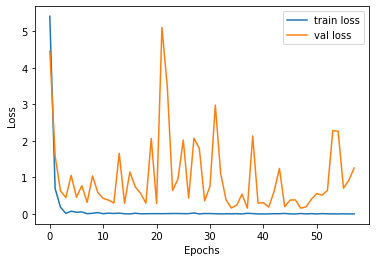

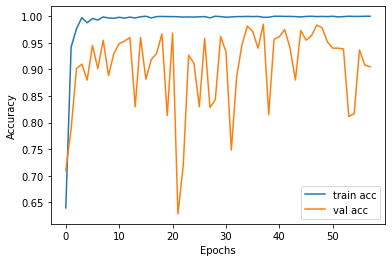

In [29]:
# Plot the training & validation losses during training versus the epochs
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

# Plot the training & validation accuracies during training versus the epochs
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

### 6.3 Precision & Recall
In order to find out which classes interfere with each other, a confusion matrix will be created.

Other metrics than accuracy will be calculated with the sklearn.metrics package like Precision and Recall.
Based on a 2 class confusion matrix (image below), the True positives, true negatives, false positives and false negatives can be calculated and different metrics can be evaluated based on that.
There are many more metrics to evaluate a model, as you can see in the following image:

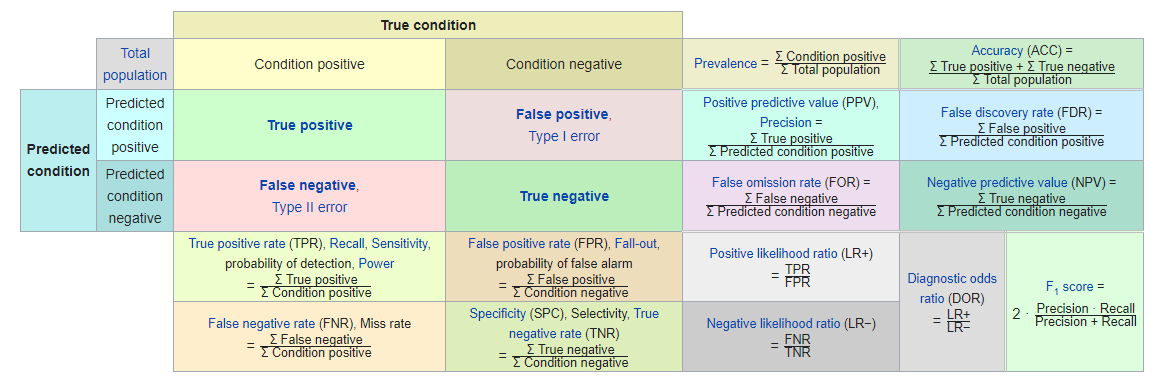

Source of Image: https://en.wikipedia.org/wiki/Precision_and_recall

We will focus on accuracy, precision and recall. <br>

The accuracy (ACC) is defined as the sum of all true positives plus the sum of all true negatives divided by the sum of the total population (total samples of images): <br>
$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}.$ <br>
It answers the question: "What proportion of all predictions on the images were actually predicted correct?" <br>
But sometimes, especially on imbalanced datasets, the evaluation of only accuracy as metric can be misleading and dangerous because accuracy alone doesn't give a good impression of the performance of the model.
Because of this fact, we need to evaluate other metrics like precision and recall to be sure to have a good model.

The Recall (also known as Sensitivity or true positive rate (TPR)) is defined as: <br>
$\text{Recall} = \frac{TP}{TP + FN}$ <br>
Recall answers the question "What proportion of actually positive conditions was identified correctly?" <br>
Or in terms of facial recognition: what proportion of actually "Markus" images was identified correctly as "Markus"?

The precision (also known as positive predictive value (PPV)) is defined as: <br>
$\text{Precision} = \frac{TP}{TP + FP}$ <br>
Precision is answering the question "What proportion of positive identifications was actually correct?" <br>
Or: What proportion of all identifications as "Markus" was actually an image of "Markus"? <br>
(Definition of recall and precision source: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)


Every class has their own value of precision and recall. For example there is the positive condition "Markus" which includes all samples of the class "Markus" and there is the negative condition "not Markus", which includes the remaining classes "Objects" and "Others". The same for the other two classes "Others" and "Objects".
Based on that, three 2x2 confusion matrices can be calculated and a precision and recall value for each class can be calculated.

In [30]:
# Import the functionality to calculate the metrics from sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# Basic code is from Fruit Example Jupyter Notebook from Prof. Dr.-Ing. Stache 
def get_metrics(data_path, N, name):
    """Get accuracy, precision and recall and confusion matrix of a dataset evaluated by the neural network.
    
    Keyword arguments:
    data_path -- string of the path of the evaluated dataset (train, validation or test dataset)
    N         -- number of total image files in the dataset
    name      -- information of used dataset (train, validation or test)
    """
    
    print("\nGenerating confusion matrix", N)
    predictions = []  # Empty list of predictions
    targets = []  # Empty list of Ground Truth of predictions
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)  # Predict class on image x
        p = np.argmax(p, axis=1)  # Number of class of the prediction
        y = np.argmax(y, axis=1)  # Number of class that is ground truth of x
        predictions = np.concatenate((predictions, p))  # Include new prediction to list
        targets = np.concatenate((targets, y))  # Include new ground truth to list
        if len(targets) >= N:
            break
    # Calculate confusion matrix based on list of predictions and ground truths       
    cm = confusion_matrix(targets, predictions)
    
    # Calculate accuracy
    print('\n\n ##' + name + ' SET##' + '\nMetrics Information on Labels: ', labels)
    acc = accuracy_score(targets, predictions)
    print('ACCURACY: ', acc)
    
    # Calculate precision
    precision = precision_score(targets, predictions, average=None)
    print('PRECISION: ', precision)
    
    # Calculate recall
    recall = recall_score(targets, predictions, average=None)
    print('RECALL:    ', recall)
    print(60*'_')
    
    return cm  # Return confusion matrix array to plot them later

# Calculate metrics for training, validation and test dataset
train_cm = get_metrics(train_path, len(image_files), 'TRAINING')
valid_cm = get_metrics(validation_path, len(validation_image_files), 'VALIDATION')
test_cm = get_metrics(test_path, len(test_image_files), 'TEST')


Generating confusion matrix 3129
Found 3129 images belonging to 3 classes.
50


 ##TRAINING SET##
Metrics Information on Labels:  ['Markus', 'Objects', 'Others']
ACCURACY:  0.9881751358261426
PRECISION:  [0.97291022 1.         0.9979716 ]
RECALL:     [0.99841144 0.99415888 0.9704142 ]
____________________________________________________________

Generating confusion matrix 615
Found 615 images belonging to 3 classes.


 ##VALIDATION SET##
Metrics Information on Labels:  ['Markus', 'Objects', 'Others']
ACCURACY:  0.9853658536585366
PRECISION:  [0.96850394 1.         0.99484536]
RECALL:     [0.99595142 0.99404762 0.965     ]
____________________________________________________________

Generating confusion matrix 349
Found 349 images belonging to 3 classes.


 ##TEST SET##
Metrics Information on Labels:  ['Markus', 'Objects', 'Others']
ACCURACY:  0.9856733524355301
PRECISION:  [0.96551724 1.         1.        ]
RECALL:     [1.         0.98958333 0.96460177]
_____________________________

#### Accuracy
The accuracy of the model on unseen data (validation and test data) is greater than 98,5 % in both the validation and test dataset which is a very good result. <br>

#### Precision
In the validation dataset the class "Markus" have the lowest precision with 96,9% and the class "Objects" have the highest with 100%. <br>
In the test dataset the class "Markus" have the lowest precision with 96,6% and the class "Objects" and "Others" have the highest with 100%.
 
#### Recall
In the validation dataset the class "Others" have the lowest recall with 96,5% and the class "Markus" have the highest with 99.6%. <br>
In the test dataset the class "Others" have the lowest recall with 96,5% and the class "Markus" has the highest with 100%.

### 6.4 Plot confusion matrix

The confusion matrix is plotted with the code from the Fruit Examples notebook of Prof. Dr-Ing. Stache.

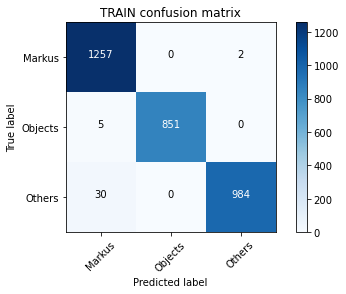

In [31]:
def plot_confusion_matrix(cm, name):
    """Plot the confusion matrix.
    
    Keyword Arguments:
    cm   --  3x3 array confusion matrix based on all 3 classes
    name --  information of used dataset (train, validation or test)
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(name + ' confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
plot_confusion_matrix(train_cm, 'TRAIN')

In the training dataset the network predicted 30 Images of "Others" falsely as "Markus", 5 images of "Objects" falsely as "Markus" and 2 images of "Markus" falsely as "Others". All of the other 3092 training images were correctly classified.

#### Confusion matrix on validation data

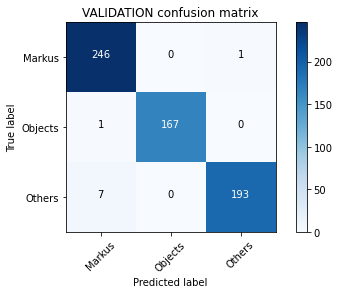

In [32]:
plot_confusion_matrix(valid_cm, 'VALIDATION')

In the validation dataset the network predicted 7 Images of "Others" falsely as "Markus", 1 image of "Objects" falsely as "Markus" and 1 image of "Markus" falsely as "Others". All of the other 606 validation images were correctly classified.

#### Confusion matrix on test data

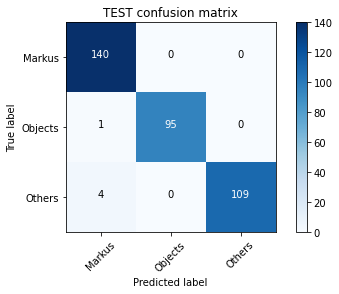

In [33]:
plot_confusion_matrix(test_cm, 'TEST')

In the test dataset the network predicted 4 Images of "Others" falsely as "Markus", 1 image of "Objects" falsely as "Markus". All of the other 344 test images were correctly classified.

# 7. Application on mobile devices or embedded systems - MobileNetV2

Since the deep learning network "InceptionResNetV2" has a memory size of 215 MB and a depth of 572, it is not very efficient for the use on mobile devices in real time apps or on embedded systems when computational power is limited. <br>
Because of that, researchers from Google released a neural network architecture, the "MobileNetV2", that is optimized for the use on mobile devices and embedded vision applications. It has a memory size of only 14 MB and a depth of layers of 88. <br>

This network has high accuracy results on image classification tasks while keeping the parameters and mathematical operations as low as possible, so that it can work fast and efficient on mobile devices. <br>
Neural networks need to work efficient these days because new mobile applications entering the market allows users to interact with the real world in realtime. The MobileNetV2 network is an improved version of the MobileNetV1 in terms like:
- 30-40% faster (on a Google Pixel phone)
- 2 times fewer mathematical operations
- higher accuracy achieved
- 30 % less parameters used
Source: https://analyticsindiamag.com/why-googles-mobilenetv2-is-a-revolutionary-next-gen-on-device-computer-vision-network/

### 7.1 Training the MobileNetV2
In the following code sections, a neural network is trained with transfer learning based on the MobileNetV2 from Google. The pipeline of the training is the same as training the InceptionResNetV2 in all the above code cells in this notebook. Data Augmentation is used in the training dataset, too. The Keras ImageData generators have to be created again, because we need to pass the preprocess_input function of the MobileNetV2 to meet the preprocessing needs of the new network. <br>

The MobileNetV2 is loaded without top layers and with all weights of the basemodel freezed. The output of the basemodel of MobileNetV2 is then flattened and then connected to a fully connected Dense layer with 200 Neuron units and a relu activation function. This layer is then connected to another Dense layer with 3 neurons with a softmax activation function (prediction layer). The top layer structure is shown in the following image:

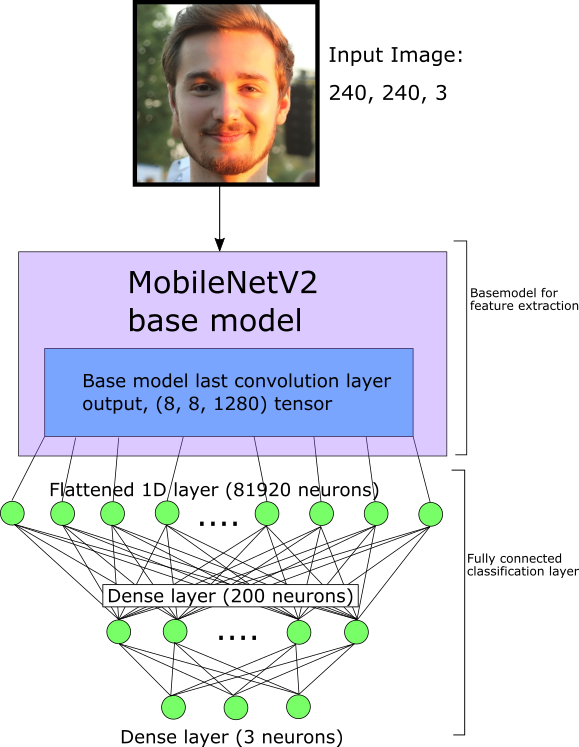

The training will be stopped with an Early-Stopping callback after 20 epochs of no improvement in validation accuracy.
Because of the similarity of the training process from the first deep learning model, the code below for the MobileNetV2 is compressed in few code cells.

#### Data Generators

In [36]:
tf.keras.backend.clear_session() # Clear tf session 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # Import MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Import preprocess specifications for MobileNetV2


# Generator for Training Dataset with Data Augmentation
gen_train = ImageDataGenerator(
  rotation_range=15,  # Rotate image randomly from -15° to 15°
  width_shift_range=0.05,  # Shift image to left or right
  height_shift_range= 0.05,  # Shift image in height
  shear_range= 0.05,  # Shear image
  zoom_range=0.05,  # Zoom into image in %
  horizontal_flip=True,  # Flip image horizontal
  vertical_flip=False,  # Flip image vertical (upside-down)
  preprocessing_function=preprocess_input)  # Preprocess input the way InceptionResNetV2 needs it, e.g. values range [-1, +1]

# Generator for Validation and Test Data (No Augmented Images)
gen = ImageDataGenerator(preprocessing_function=preprocess_input)  # rescale=1.0/255

# Generator for training data (augmented data)
train_generator = gen_train.flow_from_directory(
  train_path,  # Path to take images from
  target_size=IMAGE_SIZE,
  shuffle=True,  # Shuffle the data before creating batches
  batch_size=batch_size)  # Specifing batch size (how many images per batch)

# Generator for validation data (non-augmented data)
valid_generator = gen.flow_from_directory(
  validation_path,  # Path to take images from
  target_size=IMAGE_SIZE,
  shuffle=True,  # Shuffle the data before creating batches
  batch_size=batch_size)  # Specifing batch size (how many images per batch)

# Generator for test data (non-augmented data)
test_generator = gen.flow_from_directory(
  test_path,  # Path to take images from
  target_size=IMAGE_SIZE,
  shuffle=True,  # Shuffle the data before creating batches
  batch_size=batch_size)  # Specifing batch size (how many images per batch)

Found 3129 images belonging to 3 classes.
Found 615 images belonging to 3 classes.
Found 349 images belonging to 3 classes.


#### Define MobileNetV2 transfer learning model

In [37]:
# Define base_model as MobileNetV2 model without top layers and load imagenet weights
base_model = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

def create_model_mobileNetV2():
    """Set up the deep neural network based on MobileNetV2 model and return the created model"""
    
    # Do not train pretrained base_model weights/ freeze them
    for layer in base_model.layers:
        layer.trainable = False

    # Flatten the output of the base model
    x = Flatten()(base_model.output)
    # Dense layer with 200 neurons which is fully connected to the flattened output
    x = Dense(200,
              activation='relu')(x) # Fully connected layer with 200 neurons
    # Dense layer as prediction layer with 3 neurons
    prediction = Dense(len(folders),
                       activation='softmax')(x)
    
    # Create a model object from inputs and outputs of the whole pipeline
    model = Model(inputs=base_model.input, outputs=prediction)

    # Print the structure of the resulting deep learning model
    print(model.summary())

    # Define the cost and optimization method of the model to use in the training process
    model.compile(
      loss='categorical_crossentropy', # loss for categorical data
      optimizer='rmsprop',  #adam, nadam rmsprop
      metrics=['accuracy'])
    return model

# Instantiate our model2 object for the training, validation and testing process
model2 = create_model_mobileNetV2() 

D:\PROGRAMME\Anaconda\envs\dl\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 241, 241, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 120, 120, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 120, 120, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [38]:
# Fit the model to the training data using a generator for data augmentation
r2 = model2.fit_generator(
    # ImageGenerator of Training and validation Dataset
    train_generator,  
    validation_data=valid_generator,  
    # Specify number of epochs to run
    epochs=epochs,  
    # Integer of total number of steps (batches of samples) to yield from Training DataGenerator
    steps_per_epoch=len(image_files) // batch_size, 
    # Integer of total number of steps (batches of samples) to yield from Validation DataGenerator
    validation_steps=len(validation_image_files) // batch_size, 
    # Write status
    verbose=1, 
    # Specify callbacks
    callbacks=callbacks_list)  
print('Training done!')

Epoch 1/100
78/78 [==============================] - 46s 584ms/step - loss: 5.2697 - accuracy: 0.6691 - val_loss: 5.8717 - val_accuracy: 0.6267
Epoch 2/100
78/78 [==============================] - 45s 579ms/step - loss: 4.6035 - accuracy: 0.7151 - val_loss: 5.0387 - val_accuracy: 0.6833
Epoch 3/100
78/78 [==============================] - 45s 573ms/step - loss: 4.5936 - accuracy: 0.7151 - val_loss: 5.7361 - val_accuracy: 0.6350
Epoch 4/100
78/78 [==============================] - 45s 581ms/step - loss: 4.4527 - accuracy: 0.7232 - val_loss: 5.0299 - val_accuracy: 0.6850
Epoch 5/100
78/78 [==============================] - 44s 566ms/step - loss: 4.6514 - accuracy: 0.7109 - val_loss: 6.2719 - val_accuracy: 0.6033
Epoch 6/100
78/78 [==============================] - 44s 568ms/step - loss: 0.8938 - accuracy: 0.9424 - val_loss: 3.5784 - val_accuracy: 0.7667
Epoch 7/100
78/78 [==============================] - 44s 565ms/step - loss: 0.1719 - accuracy: 0.9883 - val_loss: 1.9934 - val_accuracy:

#### Evaluation of MobileNetV2

In [39]:
train_loss, train_acc = model2.evaluate_generator(train_generator)
val_loss, val_acc = model2.evaluate_generator(valid_generator)
test_loss, test_acc = model2.evaluate_generator(test_generator)

print('Train Accuracy: ', train_acc, '\nTrain Loss: ', train_loss, '\n' + 45*'_')
print('Validation Accuracy: ', val_acc, '\nValidation Loss: ', val_loss, '\n' + 45*'_')
print('Test Accuracy: ', test_acc, '\nTest Loss: ', test_loss)

Train Accuracy:  0.9837009 
Train Loss:  0.21570764403269524 
_____________________________________________
Validation Accuracy:  0.98373985 
Validation Loss:  0.19876581951976569 
_____________________________________________
Test Accuracy:  0.991404 
Test Loss:  0.13431758681934033


### 7.2 Single Predictions on challanging Images (Me vs. my brother)

In this section single predictions are done with the trained "MobileNetV2" network of images that are subjectively interpreted as "difficult", e.g. an image from me when wearing a facemask and images of my brother who is looking a lot like me.

In [42]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def predict_on_image(filename):
    """function to make single prediction on an image """
    # Load single image and convert to array
    img = load_img(filename, target_size=IMAGE_SIZE)
    img_plt = img_to_array(img) 
    # Reshape into a single image sample with 3 channels (tensor) and make type float32
    img = img_plt.reshape(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    img = img.astype('float32')
    # Preprocess image as what MobileNetV2 net needs for input
    img = preprocess_input(img)  
    # Predict the class of the image and plot image
    result = model2.predict(img)  
    plt.imshow(img_plt/255.0)
    plt.title('Prediction: ' + labels[np.argmax(result[0])])
    plt.show()

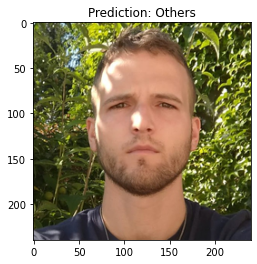

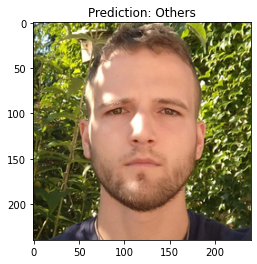

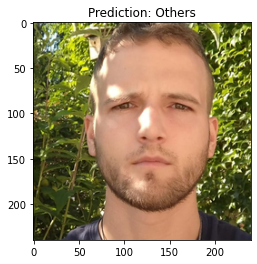

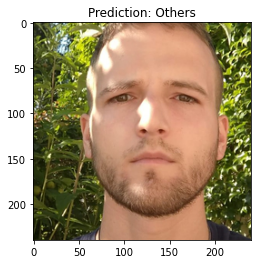

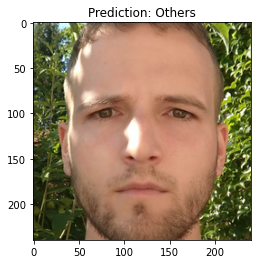

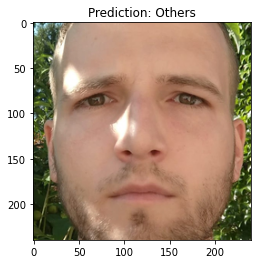

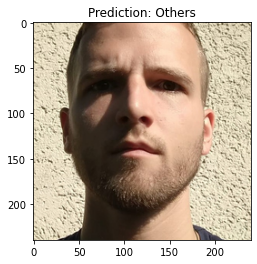

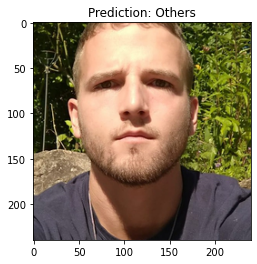

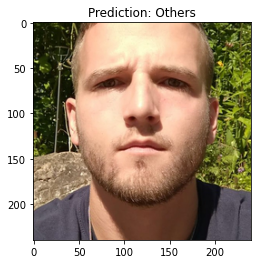

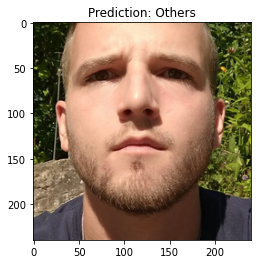

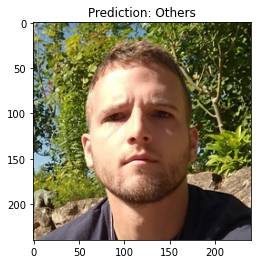

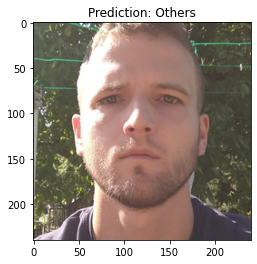

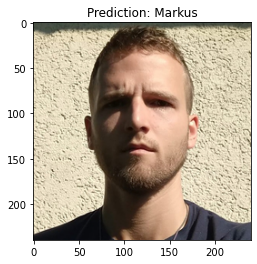

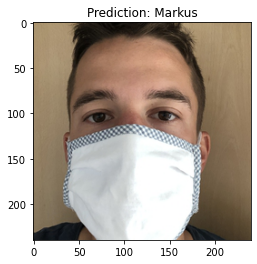

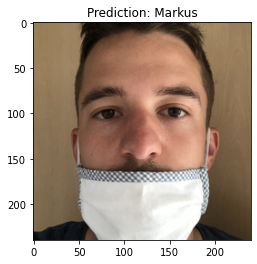

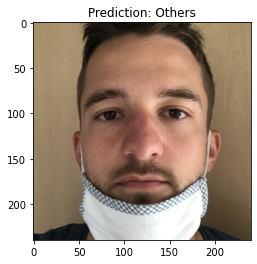

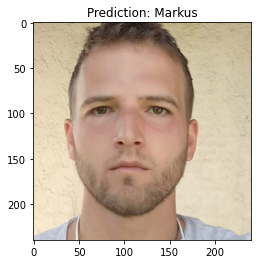

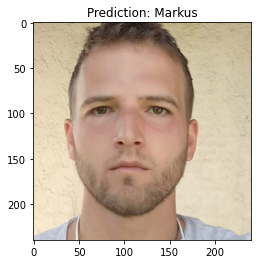

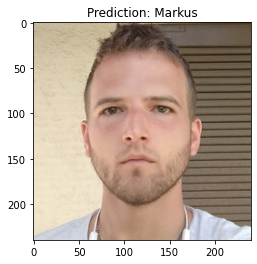

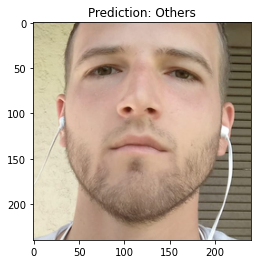

In [43]:
# Picture path of me and my brother that are quite challenging for the network
difficult_path = './Difficult_Images'
img_names = os.listdir(difficult_path) # List of image filenames

# Loop over all the difficult images and make predictions on them
for file in img_names:
    if file.endswith('.JPG') or file.endswith('.jpg'):  # Process jpg files only
        predict_on_image(os.path.join(difficult_path, file))  # Function call

The neural network is challenged when it comes to predictions on images of my brother, who is looking a lot like me. As one can see above, the network sometimes predicts images of my brother as "Markus" and sometimes as "Others". <br>
Images of my brother are not in the training dataset, so the network was not trained on images from him. <br>
My brother is looking a lot more like me than most of the people in my training set despite the fact, that many young men are in the training dataset. I expected exactly this, that the network will have trouble to identify my brother correctly as "Others".

But the results are pretty good: There are 17 single images of my brother: 13 were correctly identified as "Others" (True Positive) and 4 were incorrectly identified as "Markus" (False Negative).

From 3 images of "Markus" waring a face mask, 2 were correctly predicted as "Markus" and 1 was incorrectly predicted as "Others". I expected the image where the mask is down on my chin and the whole face can be seen to be predicted correctly but this image was classified falsely as "Others"!

# 8. Discussion of the results

On the first try, training a neural network based on the "Xception" model was done and the results were not that satisfying with validation accuracy pending around 89%. Training the Xception model is not showed in this notebook. I tried a few more models and finally the "InceptionResNetV2"-model was the best for my task in terms of accuracy, precision and recall with values around 97-99% in all three metrics! <br>
As it turned out, the decision of which model to use for transfer learning has major impact on the performance of the trained neural network.

The results of my neural network achieved with transfer learning based on the "InceptionResNetV2" model are very good and satisfying. <br>
Accuracy, precision and recall are very good in both the validation and test dataset which I did not expect to be this good before first training and evaluating the model. The result was better than my expectations.

The performance of the "MobileNetV2" in terms of validation and test accuracy was even better!

#### InceptionResNetV2 vs MobileNetV2
Validation and Test Accuracy of the "InceptionResNetV2" are 98,5% and 98,6% and for the "MobileNetV2" they are 98,4% and 99,1%. <br>
I did not expect the MobileNetV2 performing this good because it has way less layers and less mathematical operations than the InceptionResNetV2.

When high performance on accuracy, precision and recall is very important and of high priority, the InceptionResNetV2 is a very good choice for my facial recognition application. This model could be used when housedoors or doors in companies are opened based on a facial recognition application or in medical applications where False-Negatives can be fatal (For example: Prediction: No Melanoma, Ground-Truth: Melanoma). <br>
When I want my application to be very reliable and trustworthy when it comes to predictions and classification, I would suggest to use the "InceptionResNetV2" as a basemodel for transfer learning. But the MobileNetV2 is performing similiar in terms of accuracy so both models will be a very good choice for this task.

But when computational power is limited, for example if we want to implement our application on an embedded system or on a mobile device, an efficient network model is needed which uses fewer mathematical operations and which is fast. In this case the MobileNetV2 network is the best choice and with only 14 MB model size it can be downloaded and implemented easily and fast on mobile devices or embedded systems. <br>
When high priority is to have an fast and efficient model that comes with very few operational and resource needs I would suggest to use the "MobileNetv2" to use for transfer learning.

Both models are very good to implement my classification task.

#### Overfitting/ Underfitting
Overfitting occured when there was an additional fully connected layer before the prediction layer in the InceptionresNetV2. The amount of trainable parameters was too high then and so the model learnt the training data by hard. The training accuracy was very high then but the validation accuracy was bad.

On the MobileNetV2 an additional fully connected layer was needed after the flattened output of the base_model and before the prediction layer in order to get the right capacity and not having underfitting.

#### Possible solutions to predict my brother better as "Others"
To achieve even better performance when it comes to discerning my face from people looking a lot like me like my brother, there are several possibilities:
- include images of my brother in the training dataset of "Others"
- include more images of young men around my age (28 +-10 years) in "Others"
- include generally more images of people looking a lot like me in "Others"

#### Training with GPU
First, the training of the models was done on my home computer, which does not has a Nvidia GPU. Training was very slow and to train the whole notebook it would have needed more than 24 hours. So my Early-Stopping patience parameter was not a high value at first (4-6) so that training was around 14-16 hours. <br>
After that I was able to train my notebook on a friend´s computer with a Nvidia GPU: a Nvidia GeForce GTX 1080 Ti. Training both models with an early-stopping patience of 20 was done in approximately 1 hour 45 minutes and parameters could be tuned and different settings could be tested.
So training on a Nvidia GPU is highly recommended for tasks like this.

The working on this project was very interesting and fun and I learned very much! I gained much interest in the world of machine learning and deep learning and I want to continue to focus on those topics in the future.